# Visualization of the computational experiment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('.'))
from constants import RESULTS_FILE

### Fetching the results file

In [26]:
df = pd.read_csv(RESULTS_FILE)
df

,NumProducts,Run,Encoding,Time,OptValue,C,GroundRules,Variables,Constraints
0,10,0,tsp,0.069544,780.0,780.0,593.0,NaN,NaN
1,10,0,bad,0.062020,780.0,NaN,497.0,NaN,NaN
2,10,1,tsp,0.072000,810.0,810.0,653.0,NaN,NaN
3,10,1,bad,0.085001,810.0,NaN,497.0,NaN,NaN
4,10,2,tsp,0.072015,690.0,690.0,603.0,NaN,NaN
5,10,2,bad,0.064999,690.0,NaN,497.0,NaN,NaN
6,14,0,tsp,0.078983,1065.0,1065.0,1110.0,NaN,NaN
7,14,0,bad,0.704786,1065.0,NaN,917.0,NaN,NaN
8,14,1,tsp,0.125000,1125.0,1125.0,1155.0,NaN,NaN
9,14,1,bad,1.243479,1125.0,NaN,917.0,NaN,NaN


In [23]:
encodings = df['Encoding'].drop_duplicates().to_list()
encodings

['tsp', 'bad']

In [24]:
numProducts = df['NumProducts'].drop_duplicates().to_list()
numProducts

[10, 14, 18, 22, 26, 30, 34, 38]

### Preprocessing the data for plotting

In [30]:
data = {}
for encoding in encodings:
    data[encoding] = {
        'numProducts': [],
        'times': {'lbs': [], 'ubs': [], 'means': []},
        'rules': {'lbs': [], 'ubs': [], 'means': []}
    }
    df_encoding = df[df['Encoding'] == encoding]
    for numProduct in numProducts:
        data[encoding]['numProducts'].append(numProduct)
        df_numProduct = df_encoding[df_encoding['NumProducts'] == numProduct]

        times = df_numProduct['Time'].to_list()
        lb = min(times)
        ub = max(times)
        mean = float(sum(times)) / len(times)
        data[encoding]['times']['lbs'].append(lb)
        data[encoding]['times']['ubs'].append(ub)
        data[encoding]['times']['means'].append(mean)

        rules = df_numProduct['GroundRules'].to_list()
        lb = min(rules)
        ub = max(rules)
        mean = float(sum(rules)) / len(rules)
        data[encoding]['rules']['lbs'].append(lb)
        data[encoding]['rules']['ubs'].append(ub)
        data[encoding]['rules']['means'].append(mean)


## Creating plots

### Plot for computation time

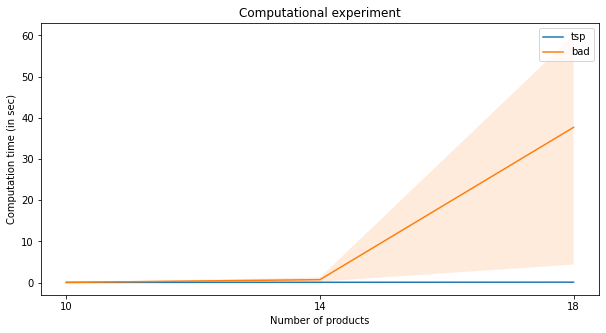

In [32]:
plt.figure(figsize=(10, 5))
plt.title('Computational experiment')
plt.xticks(numProducts)
plt.xlabel('Number of products')
plt.ylabel('Computation time (in sec)')

for encoding in encodings:
    plt.plot(data[encoding]['numProducts'], data[encoding]['times']['means'], label=encoding)
    plt.fill_between(data[encoding]['numProducts'], data[encoding]['times']['lbs'], data[encoding]['times']['ubs'], alpha=0.15)

plt.legend()
plt.show()

### Plot for number of ground rules

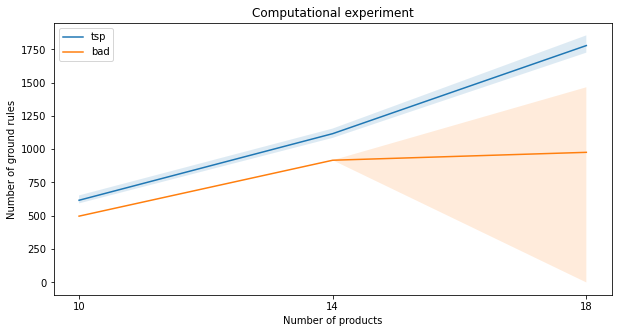

In [33]:
plt.figure(figsize=(10, 5))
plt.title('Computational experiment')
plt.xticks(numProducts)
plt.xlabel('Number of products')
plt.ylabel('Number of ground rules')

for encoding in encodings:
    if encoding in ['ilp']:
        continue
    plt.plot(data[encoding]['numProducts'], data[encoding]['rules']['means'], label=encoding)
    plt.fill_between(data[encoding]['numProducts'], data[encoding]['rules']['lbs'], data[encoding]['rules']['ubs'], alpha=0.15)

plt.legend()
plt.show()